In [9]:
import os
import glob
# import yaml
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
from astropy.cosmology import z_at_value
import matplotlib.pyplot as plt
import numpy as np
from spec_exam import F_lam_per_M
from scipy.interpolate import interp1d
from spec_stats import SN
# try:
#     import jwst    
#     # Path to pipeline config files
#     JWST_PIPELINE = os.path.dirname(jwst.__file__) + '/pipeline/'
#     print('JWST pipeline version: ', jwst.__version__)
# except:
#     print('`import jwst` failed.')
    
import grizli
import grizli.jwst
from grizli import utils, multifit
utils.set_warnings()
args = np.load('../data/multifit_data/fit_args.npy',allow_pickle=True)[0]

import seaborn as sea
import fsps

In [91]:
mb = multifit.MultiBeam('../data/niriss-point-jhk_00031.beams.fits', **args)
# mbx = multifit.MultiBeam('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/BEAMS/ERSPRIME/ERSPRIME_39170.beams.fits',**args)

load_master_fits: ../data/niriss-point-jhk_00031.beams.fits
1 NirissMirage_v1/jw00042001001_01101_00002_nis_elec.fits GR150R
2 NirissMirage_v1/jw00042001001_01101_00003_nis_elec.fits GR150R
3 NirissMirage_v1/jw00042001001_01101_00004_nis_elec.fits GR150R
4 NirissMirage_v1/jw00042001001_01101_00005_nis_elec.fits GR150R
5 NirissMirage_v1/jw00042001001_01101_00008_nis_elec.fits GR150C
6 NirissMirage_v1/jw00042001001_01101_00009_nis_elec.fits GR150C
7 NirissMirage_v1/jw00042001001_01101_00010_nis_elec.fits GR150C
8 NirissMirage_v1/jw00042001001_01101_00011_nis_elec.fits GR150C
9 NirissMirage_v1/jw00042001001_01101_00014_nis_elec.fits GR150R
10 NirissMirage_v1/jw00042001001_01101_00015_nis_elec.fits GR150R
11 NirissMirage_v1/jw00042001001_01101_00016_nis_elec.fits GR150R
12 NirissMirage_v1/jw00042001001_01101_00017_nis_elec.fits GR150R
13 NirissMirage_v1/jw00042001001_01101_00020_nis_elec.fits GR150C
14 NirissMirage_v1/jw00042001001_01101_00021_nis_elec.fits GR150C
15 NirissMirage_v1/jw0004

In [109]:
def update_model(mb, wave, flam, target_exptime=None, reset=False, random_seed=None, **kwargs):
    """
    Update the science extension of the 2D beams based on a new 1D model
    """
    mb.compute_model(spectrum_1d=(wave, flam), is_cgs=True)
    if target_exptime is not None:
        for gr in mb.PA:
            expt_scale = target_exptime / orig_expt[gr]
            for pa in mb.PA[gr]:
                for _b in mb.PA[gr][pa]:
                    mb.beams[_b].grism.exptime = mb.beams[_b].grism.exptime_orig * expt_scale
                    mb.beams[_b].grism.header['EXPTIME'] = mb.beams[_b].grism.exptime
                    mb.beams[_b].grism.data['ERR'] = mb.beams[_b].err_orig/np.sqrt(expt_scale)
    elif reset:
        for gr in mb.PA:
            expt_scale = 1.
            for pa in mb.PA[gr]:
                for _b in mb.PA[gr][pa]:
                    mb.beams[_b].grism.exptime = mb.beams[_b].grism.exptime_orig * expt_scale
                    mb.beams[_b].grism.header['EXPTIME'] = mb.beams[_b].grism.exptime
                    mb.beams[_b].grism.data['ERR'] = mb.beams[_b].err_orig/np.sqrt(expt_scale)
        
    
    np.random.seed(random_seed)
    for beam in mb.beams:

        # No bad pixels
        msk = (beam.grism.data['ERR'] == 0) | (beam.grism.data['DQ'] > 0)
        beam.grism.data['ERR'][msk] = np.median(beam.grism.data['ERR'][~msk])
        beam.grism.data['DQ'][msk] = 0

        noise = np.random.normal(size=beam.sh)*beam.grism['ERR']
        beam.grism.data['SCI'] = (beam.beam.model + beam.contam + noise).astype(np.float32)
        #print(scale_frac, scale_noise)
        beam._parse_from_data(**beam._parse_params)

    mb._parse_beam_arrays()
    mb._parse_beams(psf=False)
    mb.initialize_masked_arrays()

def make_oned_spec(mb, wave, flam, **kwargs):
    """
    Extract 1D spectrum based on an input model template
    
    kwargs can be, e.g., 
    
        bin = binning factor
        target_exptime = new exposure time per grism, seconds
        
    """
    import astropy.units as u
    
    update_model(mb, wave, flam, **kwargs)
    
    spec = mb.optimal_extract(data=mb.scif_mask, **kwargs)
    spec_flat = mb.optimal_extract(data=mb.flat_flam[mb.fit_mask], **kwargs)
    
    for k in spec:
        spec[k]['flam'] = spec[k]['flux']/spec_flat[k]['flux']
        spec[k]['eflam'] = spec[k]['err']/spec_flat[k]['flux']
        spec[k]['flam'].unit = u.erg/u.second/u.cm**2/u.Angstrom
        spec[k]['eflam'].unit = spec[k]['flam'].unit
        
    return spec
    

In [110]:
spec = make_oned_spec(mb, wave*(1+3), flam, bin=1)


None


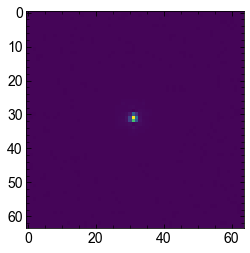

In [30]:
plt.imshow(mb.beams[0].direct.data['REF'])

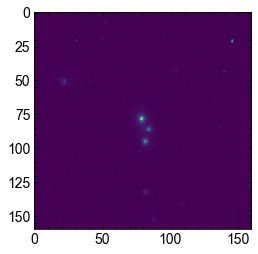

In [29]:
plt.imshow(mbx.beams[0].direct.data['REF'],vmin =0)

In [93]:
sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 4, dust_type = 2)
sp.params['tau'] = 0.2
sp.params['dust2'] = 0.3
sp.params['dust1'] = 0.3
wave, flux = sp.get_spectrum(tage = 1.5, peraa=True)
flam = F_lam_per_M(flux,wave*(1 + 4), 4, 0, sp.stellar_mass)*10**11


(3000, 8000)

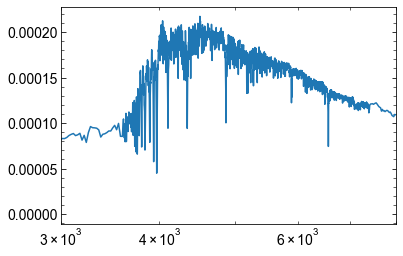

In [45]:
plt.plot(wave,flux)
plt.xscale('log')
plt.xlim(3000,8000)

F115W
nan
nan
F150W
nan
nan
F200W
nan
nan


(9000.0, 25000.0)

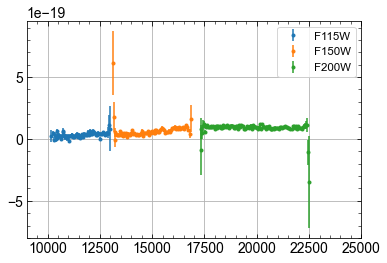

In [106]:
spec = make_oned_spec(mb, wave*(1+3), flam, bin=1)
for gr in spec:
    print(gr)
    plt.errorbar(spec[gr]['wave'][3:-3], spec[gr]['flam'][3:-3], spec[gr]['eflam'][3:-3], 
                 linestyle='None', marker='.', label=gr)
    print(np.trapz(spec[gr]['flam'][3:-3],spec[gr]['wave'][3:-3] )/np.trapz(spec[gr]['eflam'][3:-3],spec[gr]['wave'][3:-3] ))
    print(np.trapz(spec[gr]['flam'][3:-3])/np.trapz(spec[gr]['eflam'][3:-3]))

# plt.plot(wave*(1+4), flam, zorder=10, label='Input model')
plt.grid()
plt.legend()
plt.xlim(9000, 2.5e4)
# plt.ylim(-0.1e-19, 4.e-20)

(17000.0, 23000.0)

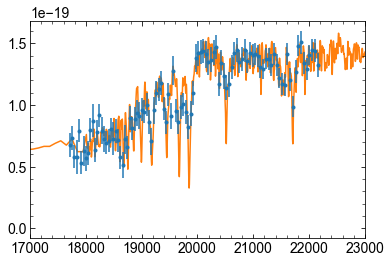

In [93]:
def gen_and_clip_200_spec(mb, wave, flam, lims = [17700, 22200],**kwargs):
    SPEC = make_oned_spec(mb, wave, flam, bin=1)

    IDX = [U for U in range(len(SPEC['F200W']['wave'])) if lims[0] < SPEC['F200W']['wave'][U] < lims[1]]
    
    return SPEC['F200W']['wave'][IDX], SPEC['F200W']['flam'][IDX], SPEC['F200W']['eflam'][IDX]

W,F,E = gen_and_clip_200_spec(mb, wave*(1+4), flam)
                          
plt.errorbar(W,F,E,linestyle='None', marker='.')
plt.plot(wave*(1+4), flam, zorder=0, label='Input model')
# plt.ylim(-0.1e-19, 4.e-19)
plt.xlim(1.7e4, 2.3e4)
# plt.axvline(17700, color = 'red')
# plt.axvline(22200, color = 'red')

In [187]:
from sim_engine import forward_model_all_beams, forward_model_grism
class Gen_spec_NIRISS_sim(object):
    def __init__(self, specz, sim_wave, sim_flam, Iused = ['F150W','F200W'], Fused = ['F150W','F200W', 'F444W'], #SNR = 10, 
                 I_lims=[[13400,16600],[17700, 22100]], phot_errterm = 0.1, random_seed=None):
        self.specz = specz
        self.c = 3E18          # speed of light angstrom s^-1
        self.I_lims = I_lims
        self.swave = sim_wave
        self.sflam = sim_flam
#         self.SNR = SNR
        self.Iused = Iused
        self.Fused = Fused
        self.random_seed = random_seed
        self.phot_err = phot_errterm
        """
        B - prefix refers to f115 ** skipping for now **
        G - prefix refers to f150 ** skipping for now **
        R - prefix refers to f200
        P - prefix refers to photometry ** skipping for now **

        specz - redshift

        """
        ##load spec
        self.sim_and_load_spec()

        ##load phot
        self.sens_wv, self.TR = np.load(template_path + 'niriss_master_tmp.npy',allow_pickle=True)
        self.b = np.load(template_path + 'niriss_bottom_precalc.npy',allow_pickle=True)
        self.dnu = np.load(template_path + 'niriss_dnu_precalc.npy',allow_pickle=True)
        self.adj = np.load(template_path + 'niriss_adj_precalc.npy',allow_pickle=True)
        self.MFWV = np.load(template_path + 'niriss_effwv_precalc.npy',allow_pickle=True)
        
        Afilts = ['F115W','F150W','F200W', 'F444W']
        self.IDP = []
        for i in range(len(Afilts)):
            if Afilts[i] in self.Fused:
                self.IDP.append(i)
        self.IDP = np.array(self.IDP)
        
        np.random.seed(self.random_seed)

        self.Pwv, self.Pfl = self.forward_model_phot(self.swave*(1+self.specz), self.sflam)
        self.Per = self.phot_err * self.Pfl
        self.Pflx = self.Pfl + np.random.normal(0, self.Per)
        
    def sim_and_load_spec(self,):
        self.mb = mb = multifit.MultiBeam(data_path + 'niriss-point-jhk_00031.beams.fits', **args)
        spec = make_oned_spec(self.mb, self.swave*(1+self.specz), self.sflam, bin=1, random_seed = self.random_seed)

        for i in range(len(self.Iused)):
            w=spec[self.Iused[i]]['wave']
            f=spec[self.Iused[i]]['flam']
            e= spec[self.Iused[i]]['eflam']
    
            IDX = [U for U in range(len(w)) if self.I_lims[i][0] < w[U] < self.I_lims[i][1]]
    
            w = np.array(w[IDX])
            f = f[IDX]
            e = e[IDX]

            BEAMS, TRANS = self.load_beams_and_trns_NS(w, instr = self.Iused[i])
           
            if self.Iused[i] == 'F150W':
                self.Gwv = w ; self.Gflx = f; self.Ger = e;
                self.GBEAMS = BEAMS; self.GTRANS = TRANS
        
            if self.Iused[i] == 'F200W':
                self.Rwv = w ; self.Rflx = f; self.Rer = e;
                self.RBEAMS = BEAMS; self.RTRANS = TRANS
        
    def load_beams_and_trns_NS(self, wv, instr = 'F200W'):
        ### Set transmission curve
        sp = fsps.StellarPopulation(imf_type = 0, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(0.002/0.019), 
                                    sfh = 4, tau = 0.6, dust_type = 1)

        model_wave, model_flux = sp.get_spectrum(tage = 3.6, peraa = True)

        ### set beams
        BEAMS = []
        PAlist = []
        for bm in self.mb.beams:
            if bm.direct.pupil == instr:
                if bm.get_dispersion_PA() not in PAlist:
                    PAlist.append(bm.get_dispersion_PA())
                    BEAMS.append(bm)

        TRANS = []
        for i in BEAMS:
            W, F = forward_model_grism(i, model_wave, np.ones(len(model_wave)))
            trans = interp1d(W,F)(wv)       
            TRANS.append(trans)

        return BEAMS, TRANS

    def forward_model_phot(self, model_wave, model_flux):
        imfl =interp1d(self.c / model_wave, (self.c/(self.c / model_wave)**2) * model_flux)

        mphot = (np.trapz(imfl(self.c /(self.sens_wv[self.IDP])).reshape([len(self.IDP),len(self.sens_wv[0])]) \
                          * self.b[self.IDP], self.dnu[self.IDP])/np.trapz(self.b[self.IDP], self.dnu[self.IDP])) * self.adj[self.IDP]
        return np.array(self.MFWV[self.IDP]), np.array(mphot)

In [204]:
sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 4, dust_type = 2)
sp.params['tau'] = 1
sp.params['dust2'] = 0.3
sp.params['dust1'] = 0.3
wave, flux = sp.get_spectrum(tage = cosmo.age(3).value, peraa=True)
flam = F_lam_per_M(flux,wave*(1 + 3), 3, 0, sp.stellar_mass)*10**11

In [205]:
GS = Gen_spec_NIRISS_sim(3, wave, flam, Iused = ['F150W','F200W'], Fused = ['F150W','F200W'], random_seed = 3)
# GS = Gen_spec_NIRISS_sim(3, wave, flam, Iused = ['F200W'], Fused = ['F200W', 'F444W'], I_lims=[[17700, 22100]], random_seed = 5)


load_master_fits: ../data/niriss-point-jhk_00031.beams.fits
1 NirissMirage_v1/jw00042001001_01101_00002_nis_elec.fits GR150R
2 NirissMirage_v1/jw00042001001_01101_00003_nis_elec.fits GR150R
3 NirissMirage_v1/jw00042001001_01101_00004_nis_elec.fits GR150R
4 NirissMirage_v1/jw00042001001_01101_00005_nis_elec.fits GR150R
5 NirissMirage_v1/jw00042001001_01101_00008_nis_elec.fits GR150C
6 NirissMirage_v1/jw00042001001_01101_00009_nis_elec.fits GR150C
7 NirissMirage_v1/jw00042001001_01101_00010_nis_elec.fits GR150C
8 NirissMirage_v1/jw00042001001_01101_00011_nis_elec.fits GR150C
9 NirissMirage_v1/jw00042001001_01101_00014_nis_elec.fits GR150R
10 NirissMirage_v1/jw00042001001_01101_00015_nis_elec.fits GR150R
11 NirissMirage_v1/jw00042001001_01101_00016_nis_elec.fits GR150R
12 NirissMirage_v1/jw00042001001_01101_00017_nis_elec.fits GR150R
13 NirissMirage_v1/jw00042001001_01101_00020_nis_elec.fits GR150C
14 NirissMirage_v1/jw00042001001_01101_00021_nis_elec.fits GR150C
15 NirissMirage_v1/jw0004

(15000.0, 50000.0)

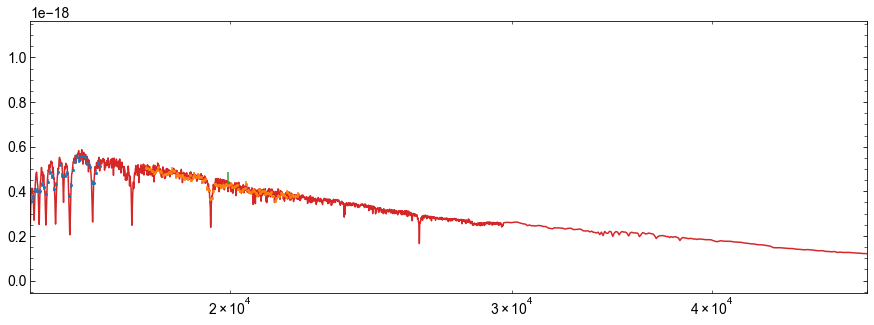

In [206]:
plt.figure(figsize = [15,5])

plt.errorbar(GS.Gwv, GS.Gflx, GS.Ger,fmt = 'o', ms = 2, )
plt.errorbar(GS.Rwv, GS.Rflx, GS.Rer,fmt = 'o', ms = 2, )
plt.errorbar(GS.Pwv, GS.Pflx, GS.Per,fmt = 'o', ms = 2, )
plt.xscale('log')
plt.plot(wave*4,flam)
plt.xlim(15e3,5e4)

(13000.0, 25000.0)

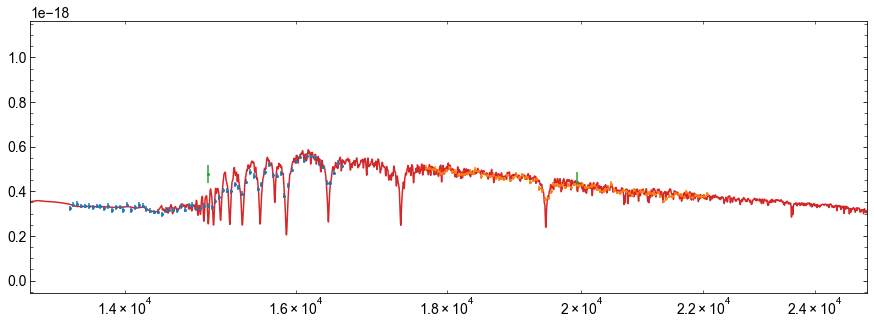

In [207]:
plt.figure(figsize = [15,5])

plt.errorbar(GS.Gwv, GS.Gflx, GS.Ger,fmt = 'o', ms = 2, )
plt.errorbar(GS.Rwv, GS.Rflx, GS.Rer,fmt = 'o', ms = 2, )
plt.errorbar(GS.Pwv, GS.Pflx, GS.Per,fmt = 'o', ms = 2, )
plt.xscale('log')
plt.plot(wave*4,flam)

plt.xlim(1.3e4,2.5e4)

In [3]:
from make_sfh_tool import Gen_NIRISS_SFH
from spec_exam import Gen_spec_NIRISS_sim
from spec_id import *
import fsps

In [453]:
specz = 3.25
agelim = cosmo.age(specz).value
sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 4, dust_type = 2)

sp.params['tau'] = 0.1   

sp.params['dust2'] = 0.
sp.params['dust1'] = 0.
wave, flux = sp.get_spectrum(tage = agelim, peraa=True)
flam = F_lam_per_M(flux,wave*(1 + specz), specz, 0, sp.stellar_mass)*10**11
GS1 = Gen_spec_NIRISS_sim(specz, wave, flam, Iused = ['F150W','F200W'], Fused = ['F150W','F200W'], 
                          I_lims=[[13400, 16800], [17700, 22100]], random_seed = 9)


fitdb = np.load('../data/posteriors/NIRISS_sim_st1_z3.25_early.npy', allow_pickle = True).item()

sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 2)
sp.params['dust2'] = fitdb['bfd']
sp.params['dust1'] = fitdb['bfd']
sp.params['logzsol'] = np.log10(fitdb['bfm'])

time, sfr, tmax = convert_sfh(get_agebins(fitdb['bfa']), [fitdb['bfm1'], 
        fitdb['bfm2'], fitdb['bfm3'], fitdb['bfm4'], fitdb['bfm5'], fitdb['bfm6'], 
        fitdb['bfm7'], fitdb['bfm8'], fitdb['bfm9'], fitdb['bfm10']], maxage = fitdb['bfa']*1E9)

sp.set_tabular_sfh(time,sfr) 

wave, flux = sp.get_spectrum(tage = fitdb['bfa'], peraa = True)

#need to fix        

flam = F_lam_per_M(flux,wave*(1+fitdb['bfz']),fitdb['bfz'],0,sp.stellar_mass)*10**fitdb['bflm']
Gmfl1 = forward_model_all_beams(GS1.GBEAMS, GS1.GTRANS, GS1.Gwv, wave*(1+fitdb['bfz']), flam)

Rmfl1 = forward_model_all_beams(GS1.RBEAMS, GS1.RTRANS, GS1.Rwv, wave*(1+fitdb['bfz']), flam)
Pwv, Pmfl1 = GS1.forward_model_phot(wave*(1+fitdb['bfz']), flam)


SFH1 = Gen_NIRISS_SFH('../data/posteriors/NIRISS_sim_st1_z3.25_early.npy', trials = 5000)

load_master_fits: ../data/niriss-point-jhk_00031.beams.fits
1 NirissMirage_v1/jw00042001001_01101_00002_nis_elec.fits GR150R
2 NirissMirage_v1/jw00042001001_01101_00003_nis_elec.fits GR150R
3 NirissMirage_v1/jw00042001001_01101_00004_nis_elec.fits GR150R
4 NirissMirage_v1/jw00042001001_01101_00005_nis_elec.fits GR150R
5 NirissMirage_v1/jw00042001001_01101_00008_nis_elec.fits GR150C
6 NirissMirage_v1/jw00042001001_01101_00009_nis_elec.fits GR150C
7 NirissMirage_v1/jw00042001001_01101_00010_nis_elec.fits GR150C
8 NirissMirage_v1/jw00042001001_01101_00011_nis_elec.fits GR150C
9 NirissMirage_v1/jw00042001001_01101_00014_nis_elec.fits GR150R
10 NirissMirage_v1/jw00042001001_01101_00015_nis_elec.fits GR150R
11 NirissMirage_v1/jw00042001001_01101_00016_nis_elec.fits GR150R
12 NirissMirage_v1/jw00042001001_01101_00017_nis_elec.fits GR150R
13 NirissMirage_v1/jw00042001001_01101_00020_nis_elec.fits GR150C
14 NirissMirage_v1/jw00042001001_01101_00021_nis_elec.fits GR150C
15 NirissMirage_v1/jw0004

In [454]:
specz = 3.25
agelim = cosmo.age(specz).value
sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = np.log10(0.75), sfh = 4, dust_type = 2)

sp.params['tau'] = 0.5

sp.params['dust2'] = 0.
sp.params['dust1'] = 0.
wave, flux = sp.get_spectrum(tage = agelim, peraa=True)
flam = F_lam_per_M(flux,wave*(1 + specz), specz, 0, sp.stellar_mass)*10**11
GS2 = Gen_spec_NIRISS_sim(specz, wave, flam, Iused = ['F150W','F200W'], Fused = ['F150W','F200W'],
                          I_lims=[[13400, 16800], [17700, 22100]], random_seed = 6)

fitdb = np.load('../data/posteriors/NIRISS_sim_st1_z3.25_t0.5_r6.npy', allow_pickle = True).item()

sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 2)
sp.params['dust2'] = fitdb['bfd']
sp.params['dust1'] = fitdb['bfd']
sp.params['logzsol'] = np.log10(fitdb['bfm'])

time, sfr, tmax = convert_sfh(get_agebins(fitdb['bfa']), [fitdb['bfm1'], 
        fitdb['bfm2'], fitdb['bfm3'], fitdb['bfm4'], fitdb['bfm5'], fitdb['bfm6'], 
        fitdb['bfm7'], fitdb['bfm8'], fitdb['bfm9'], fitdb['bfm10']], maxage = fitdb['bfa']*1E9)

sp.set_tabular_sfh(time,sfr) 

wave, flux = sp.get_spectrum(tage = fitdb['bfa'], peraa = True)

#need to fix        

flam = F_lam_per_M(flux,wave*(1+fitdb['bfz']),fitdb['bfz'],0,sp.stellar_mass)*10**fitdb['bflm']
Gmfl2 = forward_model_all_beams(GS2.GBEAMS, GS2.GTRANS, GS2.Gwv, wave*(1+fitdb['bfz']), flam)

Rmfl2 = forward_model_all_beams(GS2.RBEAMS, GS2.RTRANS, GS2.Rwv, wave*(1+fitdb['bfz']), flam)
Pwv, Pmfl2 = GS2.forward_model_phot(wave*(1+fitdb['bfz']), flam)


SFH2 = Gen_NIRISS_SFH('../data/posteriors/NIRISS_sim_st1_z3.25_t0.5_r6.npy', trials = 5000)

load_master_fits: ../data/niriss-point-jhk_00031.beams.fits
1 NirissMirage_v1/jw00042001001_01101_00002_nis_elec.fits GR150R
2 NirissMirage_v1/jw00042001001_01101_00003_nis_elec.fits GR150R
3 NirissMirage_v1/jw00042001001_01101_00004_nis_elec.fits GR150R
4 NirissMirage_v1/jw00042001001_01101_00005_nis_elec.fits GR150R
5 NirissMirage_v1/jw00042001001_01101_00008_nis_elec.fits GR150C
6 NirissMirage_v1/jw00042001001_01101_00009_nis_elec.fits GR150C
7 NirissMirage_v1/jw00042001001_01101_00010_nis_elec.fits GR150C
8 NirissMirage_v1/jw00042001001_01101_00011_nis_elec.fits GR150C
9 NirissMirage_v1/jw00042001001_01101_00014_nis_elec.fits GR150R
10 NirissMirage_v1/jw00042001001_01101_00015_nis_elec.fits GR150R
11 NirissMirage_v1/jw00042001001_01101_00016_nis_elec.fits GR150R
12 NirissMirage_v1/jw00042001001_01101_00017_nis_elec.fits GR150R
13 NirissMirage_v1/jw00042001001_01101_00020_nis_elec.fits GR150C
14 NirissMirage_v1/jw00042001001_01101_00021_nis_elec.fits GR150C
15 NirissMirage_v1/jw0004

In [353]:
fdat1 = np.load('../data/out_dict/NIRISS_sim_st1_z3.25_early.npy', allow_pickle=True).item()
fdat2 = np.load('../data/out_dict/NIRISS_sim_st1_z3.25_t0.5_r6.npy', allow_pickle=True).item()

In [354]:
t_50_grid1 = []
for i in range(len(fdat1.samples.T[0])):
    a = fdat1.samples.T[1][i]
    masses = fdat1.samples.T[2:12,i]
    lmass = fdat1.samples.T[11][i]
    time, sfr, tmax = convert_sfh(get_agebins(a), masses, maxage = a*1E9)

    T=[0]
    M=[0]
    for i in range(len(time)//2):
        mass = sfr[i*2+1] * (time[i*2+1] - time[i*2])
        M.append(M[i] + mass)
        T.append(time[i*2+1])

    sfr = sfr/ M[-1] * 10**lmass / 1E9

    lbt = np.abs(time - time[-1])[::-1]
    lbsfr = sfr[::-1]

    T=[0]
    M=[0]
    for i in range(len(lbt)//2):
        mass = lbsfr[i*2+1] * (lbt[i*2+1] - lbt[i*2])
        M.append(M[i] + mass)
        T.append(lbt[i*2+1])

    t_50_grid1.append(interp1d(M/ M[-1], T)(0.5))
    
t_50_grid2 = []
for i in range(len(fdat2.samples.T[0])):
    a = fdat2.samples.T[1][i]
    masses = fdat2.samples.T[2:12,i]
    lmass = fdat2.samples.T[11][i]
    time, sfr, tmax = convert_sfh(get_agebins(a), masses, maxage = a*1E9)

    T=[0]
    M=[0]
    for i in range(len(time)//2):
        mass = sfr[i*2+1] * (time[i*2+1] - time[i*2])
        M.append(M[i] + mass)
        T.append(time[i*2+1])

    sfr = sfr/ M[-1] * 10**lmass / 1E9

    lbt = np.abs(time - time[-1])[::-1]
    lbsfr = sfr[::-1]

    T=[0]
    M=[0]
    for i in range(len(lbt)//2):
        mass = lbsfr[i*2+1] * (lbt[i*2+1] - lbt[i*2])
        M.append(M[i] + mass)
        T.append(lbt[i*2+1])

    t_50_grid2.append(interp1d(M/ M[-1], T)(0.5))

In [355]:
xrange = np.linspace(0,agelim,100)
tau = 0.1
dtsfh =  (xrange * np.exp(-xrange/tau))[::-1]
dtsfh /= np.trapz(dtsfh, xrange*1e9)
ndtsfh1 = dtsfh / np.trapz(dtsfh, xrange)

tau = 0.5
dtsfh =  (xrange * np.exp(-xrange/tau))[::-1]
dtsfh /= np.trapz(dtsfh, xrange*1e9)
ndtsfh2 = dtsfh / np.trapz(dtsfh, xrange)

Csfh1 = []
for i in range(len(xrange)-1):
    Csfh1.append(np.trapz(ndtsfh1[::-1][0:i+2], xrange[0:i+2]))
    
icsfh1 = interp1d(Csfh1, xrange[1:])

Csfh2 = []
for i in range(len(xrange)-1):
    Csfh2.append(np.trapz(ndtsfh2[::-1][0:i+2], xrange[0:i+2]))
    
icsfh2 = interp1d(Csfh2, xrange[1:])

(0.0, 1.8)

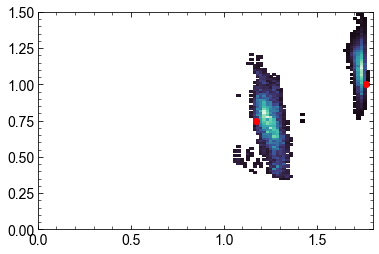

In [356]:
logwt = fdat1.logwt
logz = fdat1.logz
weight1 = np.exp(logwt - logz[-1])

logwt = fdat2.logwt
logz = fdat2.logz
weight2 = np.exp(logwt - logz[-1])

sea.histplot(x=np.ravel(t_50_grid1), y=fdat1.samples.T[0], bins=100, pthresh=0.1, cmap="mako",weights=weight1)
plt.scatter( max(xrange) - icsfh1(0.5),1, color = 'r', label = 'input values')

sea.histplot(x=np.ravel(t_50_grid2), y=fdat2.samples.T[0], bins=100, pthresh=0.1, cmap="mako",weights=weight2)
plt.scatter( max(xrange) - icsfh2(0.5),0.75, color = 'r', label = 'input values')
plt.ylim(0,1.5)
plt.xlim(0,1.8)

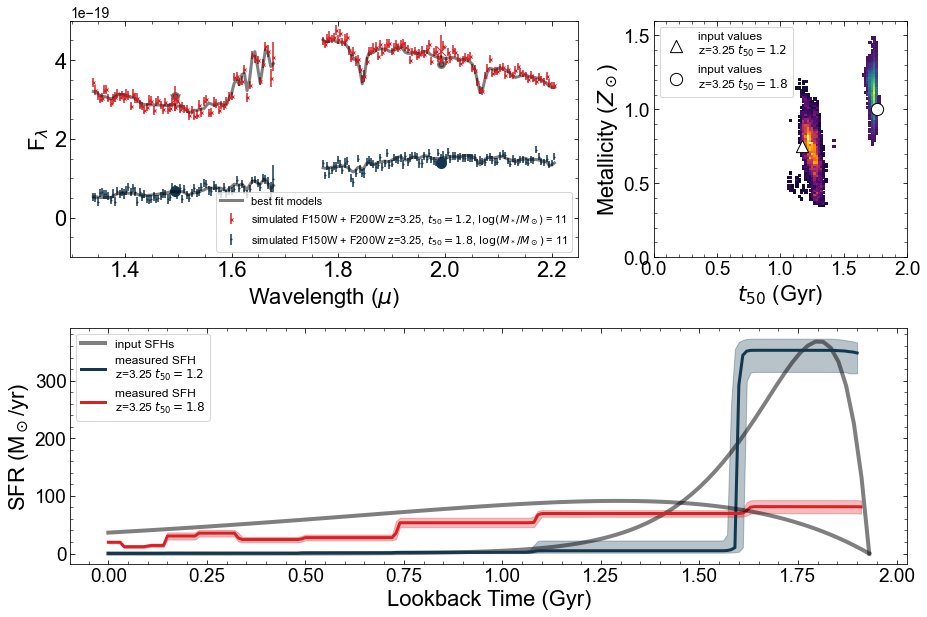

In [463]:
xrange = np.linspace(0,agelim,100)
if form == 'early':
    tau = 0.1
else:
    tau = 0.5
dtsfh =  (xrange * np.exp(-xrange/tau))[::-1]
dtsfh /= np.trapz(dtsfh, xrange*1e9)

gs = gridspec.GridSpec(2,2, width_ratios=[2,1], hspace = 0.3)

ndtsfh = dtsfh / np.trapz(dtsfh, xrange)

Csfh = []
for i in range(len(xrange)-1):
    Csfh.append(np.trapz(ndtsfh[::-1][0:i+2], xrange[0:i+2]))
    
icsfh = interp1d(Csfh, xrange[1:])

plt.figure(figsize = [15,10])
plt.subplot(gs[0,0])
plt.plot(GS2.Gwv*1e-4, Gmfl2*1.05, linewidth = 3, color = 'k', alpha = 0.5)
plt.plot(GS2.Rwv*1e-4, Rmfl2*1.05, linewidth = 3, color = 'k', alpha = 0.5)
plt.scatter(GS2.Pwv*1e-4, Pmfl2*1.05, linewidth = 3, color = 'k', alpha = 0.5)

plt.errorbar(GS2.Gwv*1e-4, GS2.Gflx*1, GS2.Ger, fmt = 'x', ms = 3, color = '#DC1F22')
plt.errorbar(GS2.Rwv*1e-4, GS2.Rflx*1, GS2.Rer, fmt = 'x', ms = 3, color = '#DC1F22',
            label = 'simulated F150W + F200W z=3.25, $t_{50} = 1.2$, $\log(M_*/M_\odot$) = 11')
plt.errorbar(GS2.Pwv*1e-4, GS2.Pflx*1, GS2.Per, fmt = 'x', ms = 10, color = '#DC1F22')

plt.errorbar(GS1.Gwv*1e-4, GS1.Gflx, GS1.Ger, fmt = 'o', ms = 1, color = '#12374E')
plt.errorbar(GS1.Rwv*1e-4, GS1.Rflx, GS1.Rer, fmt = 'o', ms = 1, color = '#12374E', 
             label = 'simulated F150W + F200W z=3.25, $t_{50} = 1.8$, $\log(M_*/M_\odot$) = 11')
plt.errorbar(GS1.Pwv*1e-4, GS1.Pflx, GS1.Per, fmt = 'o', ms = 10, color = '#12374E' )

plt.plot(GS1.Gwv*1e-4, Gmfl1, linewidth = 3, color = 'k', label = 'best fit models', alpha = 0.5, zorder = 10)
plt.plot(GS1.Rwv*1e-4, Rmfl1, linewidth = 3, color = 'k', alpha = 0.5)
plt.scatter(GS1.Pwv*1e-4, Pmfl1, linewidth = 3, color = 'k', alpha = 0.5)
plt.ylim(-1E-19,5E-19)
plt.xlabel(r'Wavelength ($\mu$)', fontsize=22)
plt.ylabel('F$_\lambda$', fontsize=22)
plt.legend(loc = 4,fontsize = 11)
plt.tick_params(axis='both', which='major', labelsize=22)

plt.subplot(gs[0,1])
sea.histplot(x=np.ravel(t_50_grid2), y=fdat2.samples.T[0], bins=100, pthresh=0.1, cmap="inferno",weights=weight2)
plt.scatter( max(xrange) - icsfh2(0.5),0.75, marker = '^',color = 'w', edgecolor = 'k',s=150, 
            label = 'input values\nz=3.25 $t_{50} = 1.2$')
sea.histplot(x=np.ravel(t_50_grid1), y=fdat1.samples.T[0], bins=100, pthresh=0.1, cmap="viridis",weights=weight1)
plt.scatter( max(xrange) - icsfh1(0.5),1, color = 'w', edgecolor = 'k',s=150, 
            label = 'input values\nz=3.25 $t_{50} = 1.8$')

plt.ylim(0,1.6)
plt.xlim(0,2)
plt.xlabel('$t_{50}$ (Gyr)', fontsize=22)
plt.ylabel('Metallicity ($Z_\odot$)', fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=19)
plt.legend(loc = 2, fontsize = 12)

plt.subplot(gs[1,:])
plt.fill_between(SFH1.LBT, SFH1.SFH_16, SFH1.SFH_84, alpha = 0.3, color = '#12374E')
plt.plot(xrange, dtsfh1*1e11,color = 'k', linewidth = 4 , alpha = 0.5,label = 'input SFHs')
plt.plot(SFH1.LBT, SFH1.SFH, color ='#12374E', linewidth = 3, label = 'measured SFH\nz=3.25 $t_{50} = 1.2$')
plt.fill_between(SFH2.LBT, SFH2.SFH_16, SFH2.SFH_84, alpha = 0.3, color = '#DC1F22')
plt.plot(SFH2.LBT, SFH2.SFH, color ='#DC1F22', linewidth = 3, label = 'measured SFH\nz=3.25 $t_{50} = 1.8$')
plt.plot(xrange, dtsfh2*1e11,color = 'k', linewidth = 4, alpha = 0.5)
plt.legend(loc = 2, fontsize = 12)
plt.xlabel('Lookback Time (Gyr)', fontsize=22)
plt.ylabel('SFR (M$_\odot$/yr)', fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=19)
plt.savefig('../plots/NIRISS/NIRISS_sim.png', bbox_inches = 'tight')    

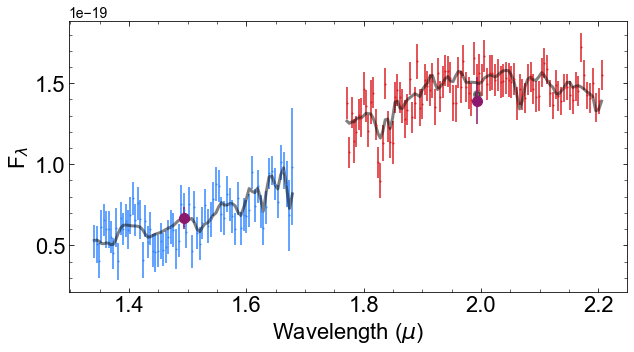

In [445]:
plt.figure(figsize=[10,5])

plt.plot(GS1.Gwv*1e-4, Gmfl1, linewidth = 3, color = 'k', label = 'best fit models', alpha = 0.5)
plt.plot(GS1.Rwv*1e-4, Rmfl1, linewidth = 3, color = 'k', alpha = 0.5)
plt.scatter(GS1.Pwv*1e-4, Pmfl1, linewidth = 3, color = 'k', alpha = 0.5)

plt.errorbar(GS1.Gwv*1e-4, GS1.Gflx, GS1.Ger, fmt = 'o', ms = 1, color = '#3488FF')
plt.errorbar(GS1.Rwv*1e-4, GS1.Rflx, GS1.Rer, fmt = 'o', ms = 1, color = '#DC1F22', 
             label = 'simulated F150W + F200W\nz=3.25 $t_{50} = 1.7$')
plt.errorbar(GS1.Pwv*1e-4, GS1.Pflx, GS1.Per, fmt = 'o', ms = 10, color = '#8B186C' )

plt.xlabel(r'Wavelength ($\mu$)', fontsize=22)
plt.ylabel('F$_\lambda$', fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.savefig('../plots/NIRISS/NIRISS_single_panel.png', bbox_inches = 'tight')    

3.251917727366487 [ 0.00101921 -0.00040194]


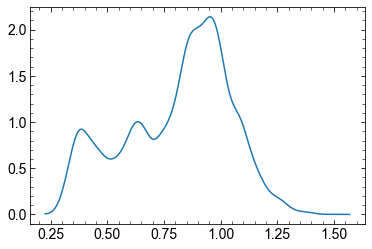

In [345]:
from spec_stats import Highest_density_region
fitdb = np.load('../data/posteriors/NIRISS_sim_st1_z3.25_t0.5_r5.npy', allow_pickle = True).item()
md, hdr, mod = Highest_density_region(fitdb['Pz'],fitdb['z'])
print(md, md - hdr)
plt.plot(fitdb['m'],fitdb['Pm'])

In [ ]:
sea.histplot(x=np.ravel(t_50_grid), bins = 100,weights=weight,kde = True, stat='probability')


In [224]:
SFH.t_50,max(xrange) - icsfh(0.5)

(1.6085196201600942, 1.762157056370977)

In [307]:
fdat = np.load('../data/out_dict/NIRISS_sim_st1_z3.25_t0.5_r6.npy', allow_pickle=True).item()

/Users/Vince.ec/miniconda3/envs/astroconda3.6/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Probability'>

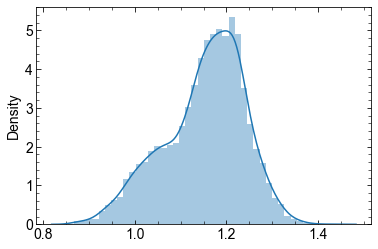

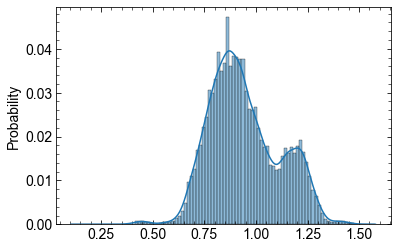

In [290]:
plt.figure()
sea.distplot(np.ravel(SFH.t_50_grid),kde = True)
# plt.xlim(1.7,1.8)

plt.figure()
sea.histplot(x=fdat.samples.T[0], bins = 100,weights=weight,kde = True, stat='probability')
# plt.xlim(1.7,1.8)

/Users/Vince.ec/miniconda3/envs/astroconda3.6/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(0.0, 1.8)

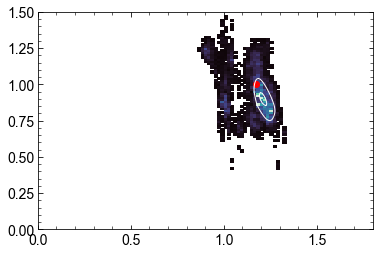

In [289]:
# sea.scatterplot(fdat.samples.T[0], np.ravel(t_50_grid))
logwt = fdat.logwt
logz = fdat.logz


weight = np.exp(logwt - logz[-1])
# sea.scatterplot(fdat.samples.T[0], np.ravel(t_50_grid), s=5, color=".15")
sea.histplot(x=np.ravel(t_50_grid), y=fdat.samples.T[0], bins=100, pthresh=0.02, cmap="mako",weights=weight)
sea.kdeplot(np.ravel(t_50_grid),fdat.samples.T[0],  levels=[.68,.95], color="w", linewidths=1,weights=weight)
plt.scatter( max(xrange) - icsfh(0.5),1, color = 'r', label = 'input values')
plt.ylim(0,1.5)
plt.xlim(0,1.8)

In [308]:
xrange = np.linspace(0,agelim,100)
tau = 0.5
dtsfh =  (xrange * np.exp(-xrange/tau))[::-1]
dtsfh /= np.trapz(dtsfh, xrange*1e9)

gs = gridspec.GridSpec(2,2, width_ratios=[2,1], hspace = 0.3)

ndtsfh = dtsfh / np.trapz(dtsfh, xrange)

Csfh = []
for i in range(len(xrange)-1):
    Csfh.append(np.trapz(ndtsfh[::-1][0:i+2], xrange[0:i+2]))
    
icsfh = interp1d(Csfh, xrange[1:])
print(max(xrange) - icsfh(0.5))

1.1706499094752818


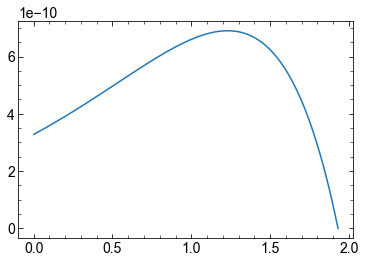

In [295]:
plt.plot(xrange, dtsfh)

In [ ]:
# m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, lm, z, d

In [148]:
fdat.samples.T[2:12,0]

array([1.00000000e+00, 1.03256184e-15, 9.08860926e-15, 3.88003409e-14,
       5.79971625e-14, 5.43680645e-14, 1.19018200e-13, 1.52091369e-13,
       2.27830951e-13, 9.53706188e-14])

In [309]:
t_50_grid = []
for i in range(len(fdat.samples.T[0])):
    a = fdat.samples.T[1][i]
    masses = fdat.samples.T[2:12,i]
    lmass = fdat.samples.T[11][i]
    time, sfr, tmax = convert_sfh(get_agebins(a), masses, maxage = a*1E9)

    T=[0]
    M=[0]
    for i in range(len(time)//2):
        mass = sfr[i*2+1] * (time[i*2+1] - time[i*2])
        M.append(M[i] + mass)
        T.append(time[i*2+1])

    sfr = sfr/ M[-1] * 10**lmass / 1E9

    lbt = np.abs(time - time[-1])[::-1]
    lbsfr = sfr[::-1]

    T=[0]
    M=[0]
    for i in range(len(lbt)//2):
        mass = lbsfr[i*2+1] * (lbt[i*2+1] - lbt[i*2])
        M.append(M[i] + mass)
        T.append(lbt[i*2+1])

    t_50_grid.append(interp1d(M/ M[-1], T)(0.5))

/Users/Vince.ec/miniconda3/envs/astroconda3.6/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/Vince.ec/miniconda3/envs/astroconda3.6/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


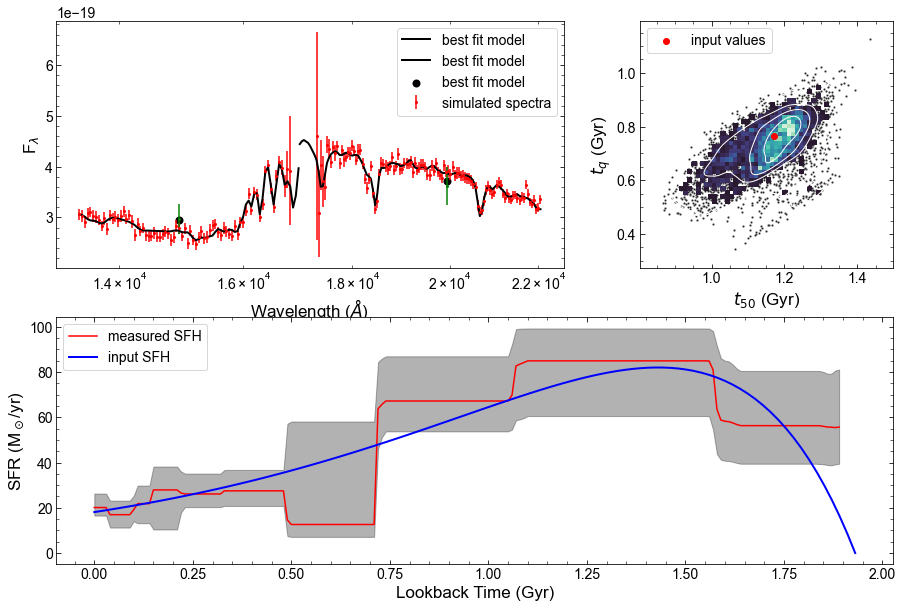

In [274]:
xrange = np.linspace(0,agelim,100)
if form == 'early':
    tau = 0.1
else:
    tau = 0.5
dtsfh =  (xrange * np.exp(-xrange/tau))[::-1]
dtsfh /= np.trapz(dtsfh, xrange*1e9)

gs = gridspec.GridSpec(2,2, width_ratios=[2,1])

ndtsfh = dtsfh / np.trapz(dtsfh, xrange)

Csfh = []
for i in range(len(xrange)-1):
    Csfh.append(np.trapz(ndtsfh[::-1][0:i+2], xrange[0:i+2]))
    
icsfh = interp1d(Csfh, xrange[1:])

plt.figure(figsize = [15,10])
plt.subplot(gs[0,0])
if setup == 1:
    plt.plot(GS.Gwv, Gmfl, linewidth = 2, color = 'k', label = 'best fit model')
plt.plot(GS.Rwv, Rmfl, linewidth = 2, color = 'k', label = 'best fit model')
plt.scatter(GS.Pwv, Pmfl, linewidth = 2, color = 'k', label = 'best fit model')

if setup == 1:
    plt.errorbar(GS.Gwv, GS.Gflx, GS.Ger, fmt = 'o', ms = 2, color = 'r', label = 'simulated spectra')
plt.errorbar(GS.Rwv, GS.Rflx, GS.Rer, fmt = 'o', ms = 2, color = 'r', )
plt.errorbar(GS.Pwv, GS.Pflx, GS.Per, fmt = 'o', ms = 2, color = 'g', )
plt.xlabel(r'Wavelength ($\AA$)', fontsize=17)
plt.ylabel('F$_\lambda$', fontsize=17)
plt.legend(fontsize = 14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xscale('log')

plt.subplot(gs[0,1])
sea.scatterplot(np.ravel(SFH.t_50_grid), np.ravel(SFH.t_50_grid)- np.ravel(SFH.t_90_grid), s=5, color=".15")
sea.histplot(x=np.ravel(SFH.t_50_grid), y=np.ravel(SFH.t_50_grid)- np.ravel(SFH.t_90_grid), bins=50, pthresh=.1, cmap="mako")
sea.kdeplot(np.ravel(SFH.t_50_grid),np.ravel(SFH.t_50_grid) - np.ravel(SFH.t_90_grid), levels=5, color="w", linewidths=1)
plt.scatter(max(xrange) - icsfh(0.5),(max(xrange) - icsfh(0.5)) - (max(xrange) - icsfh(0.9)), color = 'r', label = 'input values')
plt.xlabel('$t_{50}$ (Gyr)', fontsize=17)
plt.ylabel('$t_{q}$ (Gyr)', fontsize=17)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(loc = 2, fontsize = 14)

plt.subplot(gs[1,:])
plt.plot(SFH.LBT, SFH.SFH, color ='r', label = 'measured SFH')
plt.fill_between(SFH.LBT, SFH.SFH_16, SFH.SFH_84, alpha = 0.3, color = 'k')
plt.plot(xrange, dtsfh*1e11,color = 'b', linewidth = 2 ,label = 'input SFH')
plt.legend(loc = 2, fontsize = 14)
plt.xlabel('Lookback Time (Gyr)', fontsize=17)
plt.ylabel('SFR (M$_\odot$/yr)', fontsize=17)
plt.tick_params(axis='both', which='major', labelsize=14)
# plt.savefig('../plots/NIRISS/NIRISS_sim1.png', bbox_inches = 'tight')    

In [51]:
SFH1 = Gen_NIRISS_SFH('../data/posteriors/NIRISS_sim_st2_z4.0_early.npy', trials = 5000)
SFH2 = Gen_NIRISS_SFH('../data/posteriors/NIRISS_sim_st2_z4.0_late.npy', trials = 5000)

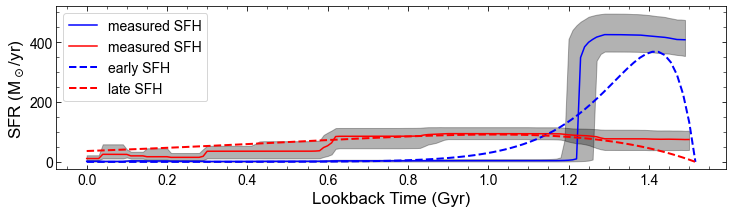

In [52]:
xrange = np.linspace(0,agelim,100)
dtsfh1 =  (xrange * np.exp(-xrange/0.1))[::-1]
dtsfh1 /= np.trapz(dtsfh1, xrange*1e9)

dtsfh2 =  (xrange * np.exp(-xrange/0.5))[::-1]
dtsfh2 /= np.trapz(dtsfh2, xrange*1e9)

plt.figure(figsize=[12,3])
plt.plot(SFH1.LBT, SFH1.SFH, color ='b', label = 'measured SFH')
plt.fill_between(SFH1.LBT, SFH1.SFH_16, SFH1.SFH_84, alpha = 0.3, color = 'k')
plt.plot(SFH2.LBT, SFH2.SFH, color ='r', label = 'measured SFH')
plt.fill_between(SFH2.LBT, SFH2.SFH_16, SFH2.SFH_84, alpha = 0.3, color = 'k')
plt.plot(xrange, dtsfh1*1e11,'--',color = 'b', linewidth = 2 ,label = 'early SFH')
plt.plot(xrange, dtsfh2*1e11,'--',color = 'r', linewidth = 2 ,label = 'late SFH')

plt.legend(loc = 2, fontsize = 14)
plt.xlabel('Lookback Time (Gyr)', fontsize=17)
plt.ylabel('SFR (M$_\odot$/yr)', fontsize=17)
plt.tick_params(axis='both', which='major', labelsize=14)
# plt.savefig('../plots/NIRISS/NIRISS_sim1.png', bbox_inches = 'tight')    

In [201]:
class Photometry_niriss(object):
    def __init__(self,wv,fl,er,filter_number):
        self.wv = wv
        self.fl = fl
        self.er = er
        self.filter_number = filter_number

    def Get_Sensitivity(self, filter_num = 0):
        if filter_num != 0:
            self.filter_number = filter_num

        f = open(hpath + 'python_git_downloads/eazy-photoz/filters/FILTER.RES.latest', 'r')
        data = f.readlines()
        rows = []
        for i in range(len(data)):
            rows.append(data[i].split())
        i = 0
        sens_data = []
        while i < len(data):
            sdata = []
            amount = int(rows[i][0])
            for u in range(amount):
                r = np.array(rows[i + u + 1])
                sdata.append(r.astype(np.float))
            sens_data.append(sdata)
            i = i + amount + 1

        sens_wave = []
        sens_func = []
        s_wave = []
        s_func = []
        for i in range(len(sens_data[self.filter_number - 1])):
            s_wave.append(sens_data[self.filter_number - 1][i][1])
            s_func.append(sens_data[self.filter_number - 1][i][2])

        for i in range(len(s_func)):
            if .001 < s_func[i]:
                sens_func.append(s_func[i])
                sens_wave.append(s_wave[i])

        self.sens_wv = np.array(sens_wave)
        self.trans = np.array(sens_func)

    def Photo(self):
        wave = self.wv * atocm
        filtnu = c /(self.sens_wv * atocm)
        nu = c / wave
        fnu = (c/nu**2) * self.fl
        Fnu = interp1d(nu, fnu)(filtnu)
        ernu = (c/nu**2) * self.er
        Ernu = interp1d(nu, ernu)(filtnu)

        energy = 1 / (h *filtnu)

        top1 = Fnu * energy * self.trans
        top = np.trapz(top1, filtnu)
        bottom1 = self.trans * energy
        bottom = np.trapz(bottom1, filtnu)
        photonu = top / bottom

        tp = np.trapz(((self.trans * np.log(self.sens_wv)) / self.sens_wv), self.sens_wv)
        bm = np.trapz(self.trans / self.sens_wv, self.sens_wv)

        wave_eff = np.exp(tp / bm)

        photo = photonu * (c / (wave_eff * atocm) ** 2)

        self.eff_wv = wave_eff
        self.photo = photo
        self.photo_er = Sig_int(filtnu,Ernu,self.trans,energy) * (c / (wave_eff * atocm) ** 2)

    def Photo_clipped(self):

        IDX = [U for U in range(len(self.sens_wv)) if self.wv[0] < self.sens_wv[U] < self.wv[-1]]

        wave = self.wv * atocm
        filtnu = c /(self.sens_wv[IDX] * atocm)
        nu = c / wave
        fnu = (c/nu**2) * self.fl
        Fnu = interp1d(nu, fnu)(filtnu)
        ernu = (c/nu**2) * self.er
        Ernu = interp1d(nu, ernu)(filtnu)

        energy = 1 / (h *filtnu)

        top1 = Fnu * energy * self.trans[IDX]
        top = np.trapz(top1, filtnu)
        bottom1 = self.trans[IDX] * energy
        bottom = np.trapz(bottom1, filtnu)
        photonu = top / bottom

        tp = np.trapz(((self.trans * np.log(self.sens_wv)) / self.sens_wv), self.sens_wv)
        bm = np.trapz(self.trans / self.sens_wv, self.sens_wv)

        wave_eff = np.exp(tp / bm)

        photo = photonu * (c / (wave_eff * atocm) ** 2)

        self.eff_wv = wave_eff
        self.photo = photo
        self.photo_er = Sig_int(filtnu,Ernu,self.trans[IDX],energy) * (c / (wave_eff * atocm) ** 2)
        
    def Photo_model(self,mwv,mfl):

        wave = mwv * atocm
        filtnu = c /(self.sens_wv * atocm)
        nu = c / wave
        fnu = (c/nu**2) * mfl
        Fnu = interp1d(nu, fnu)(filtnu)

        energy = 1 / (h *filtnu)

        top1 = Fnu * energy * self.trans
        top = np.trapz(top1, filtnu)
        bottom1 = self.trans * energy
        bottom = np.trapz(bottom1, filtnu)
        photonu = top / bottom

        tp = np.trapz(((self.trans * np.log(self.sens_wv)) / self.sens_wv), self.sens_wv)
        bm = np.trapz(self.trans / self.sens_wv, self.sens_wv)

        wave_eff = np.exp(tp / bm)
        photo = photonu * (c / (wave_eff * atocm) ** 2)
        
        self.eff_mwv = wave_eff
        self.mphoto = photo

    def FWHM(self):
        top = np.trapz((self.trans * np.log(self.sens_wv/self.eff_wv)**2) / self.sens_wv, self.sens_wv)
        bot = np.trapz(self.trans / self.sens_wv, self.sens_wv)
        sigma = np.sqrt(top/bot)

        self.fwhm = np.sqrt(8*np.log(2))*sigma * self.eff_wv

  351   720 jwst_niriss_f115w v20160902163017 lambda_c= 1.1496e+04
    
  352   720 jwst_niriss_f150w v20160902163017 lambda_c= 1.4935e+04

  353   720 jwst_niriss_f200w v20160902163017 lambda_c= 1.9930e+04
    
  358   720 jwst_niriss_f444w v20160902163017 lambda_c= 4.4277e+04

In [137]:
ew = [1.1496e+04,1.4935e+04,1.9930e+04,4.4277e+04]
filt = ['F115W', 'F150W', 'F200W', 'F444W']
tmp_num = [351,352, 353, 358]

In [150]:
model_photDF = pd.DataFrame({'eff_wv':ew, 'tmp_num':tmp_num})

In [151]:
model_photDF.to_pickle('../templates/niriss_model_photometry_list.pkl')


In [146]:
WV = wave
FL = flam
ER = np.ones(len(WV))
pht = Photometry_niriss(WV,FL,ER,203)

sens=[]
trans=[]
for i in model_photDF.index:
    pht.Get_Sensitivity(model_photDF.tmp_num[i])
    isens = np.linspace(pht.sens_wv[0],pht.sens_wv[-1],200)
    itrans = interp1d(pht.sens_wv,pht.trans)(isens)
    
    sens.append(isens)
    trans.append(itrans)
np.save('../templates/niriss_master_tmp',[sens,trans])

In [148]:
c=3E18          # speed of light cm s^-1

sens_wv, trans = np.load('../templates/niriss_master_tmp.npy')

b=[]
dnu=[]
adj=[]
meffwv = []
for i in range(len(sens_wv)):
    b.append(trans[i] * 1 / (c /(sens_wv[i])))

    dnu.append(c /(sens_wv[i]))

    adj.append(c / (model_photDF.eff_wv[model_photDF.index[i]]) ** 2)

    meffwv.append(model_photDF.eff_wv[model_photDF.index[i]])
np.save('../templates/niriss_bottom_precalc',b)
np.save('../templates/niriss_dnu_precalc',dnu)
np.save('../templates/niriss_adj_precalc',adj)
np.save('../templates/niriss_effwv_precalc',meffwv)

In [ ]:
dat = 